In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["2nd_stage"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['2nd_stage']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-22 06:03:35.238867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 06:03:35.310142: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-22 06:03:35.772552: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_095


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_2nd_stage_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [02:12<00:00,  2.09it/s]


,anglez,anglez_diff_abs,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,target,...,anglez_rolling_median_100_shift_1000,enmo_rolling_median_100_shift_1000,anglez_diff_abs_rolling_median_100_shift_1000,enmo_diff_abs_rolling_median_100_shift_1000,anglez_rolling_square_mean_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_rolling_square_mean_100_shift_1000,enmo_diff_abs_rolling_square_mean_100_shift_1000,reduce_step,fold
622,-1.160092,5.391342,-1.160092,0.049821,0.022942,0.049822,1797.5,6.5,32397.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14939,3
623,-6.169150,4.236796,-6.169149,0.026333,0.008512,0.026335,117.5,0.0,32517.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14963,3
624,-14.701716,3.183992,-14.701717,0.033279,0.007212,0.033278,237.5,0.0,32637.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14987,3
625,-12.253108,3.600733,-12.253112,0.057471,0.028133,0.057472,357.5,0.0,32757.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15011,3
626,-6.187904,3.673754,-6.187906,0.049892,0.030817,0.049891,477.5,0.0,32877.5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15035,3


(877617, 856)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG["2nd_stage"]["xgboost"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81851
[100]	eval-rmse:1.15416
[200]	eval-rmse:0.99097
[300]	eval-rmse:0.94895
[400]	eval-rmse:0.93496
[500]	eval-rmse:0.92970
[600]	eval-rmse:0.92807
[700]	eval-rmse:0.92620
[800]	eval-rmse:0.92469
[900]	eval-rmse:0.92388
[1000]	eval-rmse:0.92271
[1100]	eval-rmse:0.92208
[1200]	eval-rmse:0.92147
[1300]	eval-rmse:0.92101
[1400]	eval-rmse:0.92065
[1500]	eval-rmse:0.92020
[1600]	eval-rmse:0.91979
[1700]	eval-rmse:0.91954
[1800]	eval-rmse:0.91924
[1900]	eval-rmse:0.91907
[2000]	eval-rmse:0.91871
[2100]	eval-rmse:0.91854
[2184]	eval-rmse:0.91862


 20%|██        | 1/5 [01:32<06:10, 92.73s/it]

== fold 1 ==
[0]	eval-rmse:1.70192
[100]	eval-rmse:1.10017
[200]	eval-rmse:0.95334
[300]	eval-rmse:0.91519
[400]	eval-rmse:0.89939
[500]	eval-rmse:0.89208
[600]	eval-rmse:0.88893
[700]	eval-rmse:0.88684
[800]	eval-rmse:0.88531
[900]	eval-rmse:0.88396
[1000]	eval-rmse:0.88257
[1100]	eval-rmse:0.88165
[1200]	eval-rmse:0.88059
[1300]	eval-rmse:0.87989
[1400]	eval-rmse:0.87921
[1500]	eval-rmse:0.87877
[1600]	eval-rmse:0.87817
[1700]	eval-rmse:0.87770
[1800]	eval-rmse:0.87730
[1900]	eval-rmse:0.87707
[2000]	eval-rmse:0.87672
[2100]	eval-rmse:0.87638
[2200]	eval-rmse:0.87582
[2300]	eval-rmse:0.87550
[2400]	eval-rmse:0.87534
[2500]	eval-rmse:0.87531
[2600]	eval-rmse:0.87501
[2700]	eval-rmse:0.87501
[2800]	eval-rmse:0.87483
[2900]	eval-rmse:0.87469
[2975]	eval-rmse:0.87474


 40%|████      | 2/5 [03:33<05:27, 109.07s/it]

== fold 2 ==
[0]	eval-rmse:1.73993
[100]	eval-rmse:1.12748
[200]	eval-rmse:0.97795
[300]	eval-rmse:0.93702
[400]	eval-rmse:0.92307
[500]	eval-rmse:0.91691
[600]	eval-rmse:0.91478
[700]	eval-rmse:0.91372
[800]	eval-rmse:0.91293
[900]	eval-rmse:0.91211
[1000]	eval-rmse:0.91116
[1100]	eval-rmse:0.91047
[1200]	eval-rmse:0.90991
[1300]	eval-rmse:0.90932
[1400]	eval-rmse:0.90879
[1500]	eval-rmse:0.90850
[1600]	eval-rmse:0.90826
[1700]	eval-rmse:0.90817
[1800]	eval-rmse:0.90800
[1900]	eval-rmse:0.90783
[2000]	eval-rmse:0.90781
[2100]	eval-rmse:0.90768
[2182]	eval-rmse:0.90770


 60%|██████    | 3/5 [05:04<03:21, 100.95s/it]

== fold 3 ==
[0]	eval-rmse:1.71284
[100]	eval-rmse:1.08291
[200]	eval-rmse:0.92674
[300]	eval-rmse:0.88440
[400]	eval-rmse:0.87068
[500]	eval-rmse:0.86553
[600]	eval-rmse:0.86427
[700]	eval-rmse:0.86393
[800]	eval-rmse:0.86331
[900]	eval-rmse:0.86273
[1000]	eval-rmse:0.86251
[1100]	eval-rmse:0.86202
[1200]	eval-rmse:0.86135
[1300]	eval-rmse:0.86118
[1400]	eval-rmse:0.86106
[1500]	eval-rmse:0.86099
[1600]	eval-rmse:0.86068
[1700]	eval-rmse:0.86053
[1800]	eval-rmse:0.86027
[1900]	eval-rmse:0.86027
[1923]	eval-rmse:0.86028


 80%|████████  | 4/5 [06:24<01:32, 92.67s/it] 

== fold 4 ==
[0]	eval-rmse:1.78935
[100]	eval-rmse:1.13905
[200]	eval-rmse:0.97923
[300]	eval-rmse:0.93808
[400]	eval-rmse:0.92632
[500]	eval-rmse:0.92204
[600]	eval-rmse:0.92062
[700]	eval-rmse:0.91933
[800]	eval-rmse:0.91837
[900]	eval-rmse:0.91759
[1000]	eval-rmse:0.91702
[1100]	eval-rmse:0.91641
[1200]	eval-rmse:0.91592
[1300]	eval-rmse:0.91568
[1400]	eval-rmse:0.91545
[1500]	eval-rmse:0.91529
[1600]	eval-rmse:0.91524
[1664]	eval-rmse:0.91524


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81548
[100]	eval-rmse:1.17429
[200]	eval-rmse:1.00568
[300]	eval-rmse:0.95620
[400]	eval-rmse:0.93814
[500]	eval-rmse:0.93156
[600]	eval-rmse:0.92787
[700]	eval-rmse:0.92633
[800]	eval-rmse:0.92528
[900]	eval-rmse:0.92476
[1000]	eval-rmse:0.92434
[1100]	eval-rmse:0.92394
[1200]	eval-rmse:0.92352
[1300]	eval-rmse:0.92331
[1400]	eval-rmse:0.92327
[1500]	eval-rmse:0.92320
[1600]	eval-rmse:0.92307
[1672]	eval-rmse:0.92322


 20%|██        | 1/5 [01:10<04:43, 70.99s/it]

== fold 1 ==
[0]	eval-rmse:1.69808
[100]	eval-rmse:1.11169
[200]	eval-rmse:0.95968
[300]	eval-rmse:0.91281
[400]	eval-rmse:0.89440
[500]	eval-rmse:0.88660
[600]	eval-rmse:0.88279
[700]	eval-rmse:0.88071
[800]	eval-rmse:0.87868
[900]	eval-rmse:0.87700
[1000]	eval-rmse:0.87618
[1100]	eval-rmse:0.87548
[1200]	eval-rmse:0.87442
[1300]	eval-rmse:0.87392
[1400]	eval-rmse:0.87339
[1500]	eval-rmse:0.87307
[1600]	eval-rmse:0.87253
[1700]	eval-rmse:0.87214
[1800]	eval-rmse:0.87211
[1900]	eval-rmse:0.87187
[2000]	eval-rmse:0.87164
[2075]	eval-rmse:0.87169


 40%|████      | 2/5 [02:38<04:01, 80.61s/it]

== fold 2 ==
[0]	eval-rmse:1.74181
[100]	eval-rmse:1.17102
[200]	eval-rmse:1.01868
[300]	eval-rmse:0.96857
[400]	eval-rmse:0.94692
[500]	eval-rmse:0.93760
[600]	eval-rmse:0.93275
[700]	eval-rmse:0.92869
[800]	eval-rmse:0.92609
[900]	eval-rmse:0.92415
[1000]	eval-rmse:0.92306
[1100]	eval-rmse:0.92202
[1200]	eval-rmse:0.92102
[1300]	eval-rmse:0.92005
[1400]	eval-rmse:0.91909
[1500]	eval-rmse:0.91849
[1600]	eval-rmse:0.91792
[1700]	eval-rmse:0.91757
[1800]	eval-rmse:0.91737
[1900]	eval-rmse:0.91715
[2000]	eval-rmse:0.91704
[2100]	eval-rmse:0.91705
[2106]	eval-rmse:0.91706


 60%|██████    | 3/5 [04:05<02:47, 83.83s/it]

== fold 3 ==
[0]	eval-rmse:1.70748
[100]	eval-rmse:1.12433
[200]	eval-rmse:0.97707
[300]	eval-rmse:0.93687
[400]	eval-rmse:0.92337
[500]	eval-rmse:0.91822
[600]	eval-rmse:0.91473
[700]	eval-rmse:0.91302
[800]	eval-rmse:0.91174
[900]	eval-rmse:0.91102
[1000]	eval-rmse:0.91051
[1100]	eval-rmse:0.91024
[1200]	eval-rmse:0.90989
[1300]	eval-rmse:0.90969
[1400]	eval-rmse:0.90960
[1500]	eval-rmse:0.90943
[1570]	eval-rmse:0.90959


 80%|████████  | 4/5 [05:13<01:17, 77.34s/it]

== fold 4 ==
[0]	eval-rmse:1.77996
[100]	eval-rmse:1.18069
[200]	eval-rmse:1.02860
[300]	eval-rmse:0.98617
[400]	eval-rmse:0.97091
[500]	eval-rmse:0.96454
[600]	eval-rmse:0.96123
[700]	eval-rmse:0.95909
[800]	eval-rmse:0.95749
[900]	eval-rmse:0.95615
[1000]	eval-rmse:0.95525
[1100]	eval-rmse:0.95453
[1200]	eval-rmse:0.95413
[1300]	eval-rmse:0.95387
[1400]	eval-rmse:0.95358
[1500]	eval-rmse:0.95307
[1600]	eval-rmse:0.95253
[1700]	eval-rmse:0.95209
[1800]	eval-rmse:0.95176
[1900]	eval-rmse:0.95144
[2000]	eval-rmse:0.95126
[2100]	eval-rmse:0.95097
[2200]	eval-rmse:0.95070
[2300]	eval-rmse:0.95065
[2400]	eval-rmse:0.95068
[2455]	eval-rmse:0.95069


100%|██████████| 5/5 [06:51<00:00, 82.33s/it]


## Dynamic-Range NMS

<AxesSubplot: >

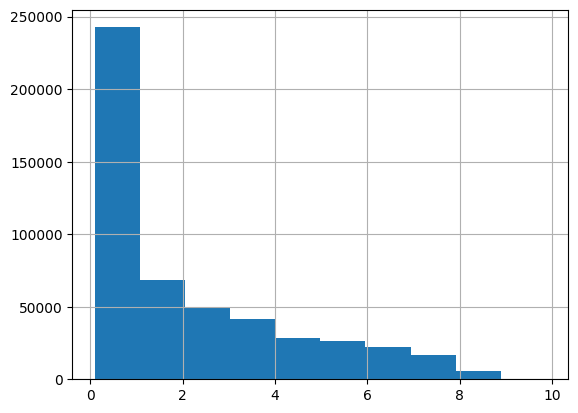

In [4]:
train = train[train["score"] > 0.1]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:06<00:00, 45.33it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7340


event   tolerance
onset   12           0.132748
        36           0.504688
        60           0.695458
        90           0.791913
        120          0.828158
        150          0.848888
        180          0.861126
        240          0.876992
        300          0.884006
        360          0.890247
wakeup  12           0.105385
        36           0.497060
        60           0.700309
        90           0.784993
        120          0.833454
        150          0.861159
        180          0.873960
        240          0.892582
        300          0.903500
        360          0.912548
dtype: float64